In [105]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

import matplotlib.pyplot as plt

###### predict date range ######
# pd.date_range(start="2021-12-26",end="2022-01-01")
# pd.date_range(start="2022-01-23",end="2022-01-29")

In [106]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
  X = []
  y = []
  start = start + window
  if end is None:
    end = len(dataset) - horizon
  for i in range(start, end):
    indices = range(i-window, i)
    X.append(dataset[indices])
    indicey = range(i+1, i+1+horizon)
    y.append(target[indicey])
  return np.array(X), np.array(y)

In [107]:
f1 = pd.concat([pd.read_csv('../Data/ground_temp_train.csv'), pd.read_csv('../Data/ground_temp_test.csv')])
f2 = pd.concat([pd.read_csv('../Data/sunrise_sunset_train.csv'), pd.read_csv('../Data/sunrise_sunset_test.csv')])

f1['년도'] = pd.to_datetime(f1['일시']).apply(lambda x: x.year)
f1['월'] = pd.to_datetime(f1['일시']).apply(lambda x: x.month)
f1['일'] = pd.to_datetime(f1['일시']).apply(lambda x: x.day)
f1['시'] = pd.to_datetime(f1['일시']).apply(lambda x: x.hour)

f1.drop(columns=['일시'],inplace=True)

f2['Unnamed: 0'] = f2['Unnamed: 0'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
f2['년도'] = pd.to_datetime(f2['Unnamed: 0']).apply(lambda x: x.year)
f2['월'] = pd.to_datetime(f2['Unnamed: 0']).apply(lambda x: x.month)
f2['일'] = pd.to_datetime(f2['Unnamed: 0']).apply(lambda x: x.day)

f2.drop(columns=['Unnamed: 0'],inplace=True)

<AxesSubplot:xlabel='년월일'>

/Users/hongjiwon/miniforge3/envs/tf/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hongjiwon/miniforge3/envs/tf/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hongjiwon/miniforge3/envs/tf/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


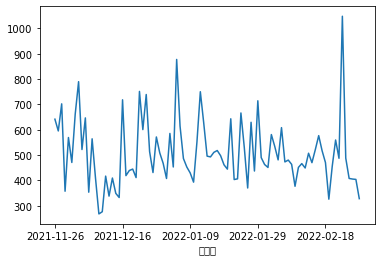

In [108]:
test_idx = 129448
valid_idx = 89936

df = pd.read_csv('../Data/smart_farm_final.csv')
df['열공급량(kWh'] = df['열공급량(kWh)'].fillna(0)
# df['열공급량(kWh)'] = df['열공급량(kWh)'] * 1000

df.iloc[:test_idx].groupby('년월일')['열공급량(kWh)'].sum().plot()

In [109]:

# f1 merge
df = pd.merge(df,f1, on=['년도','월','일','시'], how='left')
# f2 merge
df = pd.merge(df,f2, on=['년도','월','일'], how='left')

df.set_index('시간',inplace=True)
df.drop(columns=['년월일', '년도', '월', '일', '시', '분'],inplace=True)
print("total data: ",df.shape)

print("train data: ",df.iloc[:test_idx].shape)
print("test data: ",df.iloc[test_idx:].shape)

total data:  (148168, 54)
train data:  (129448, 54)
test data:  (18720, 54)


In [110]:
dummy_lst = ['차광스크린_광도조절','차광스크린_개방조절', '차열스크린_온도조절', '차열스크린_광도조절', '차열스크린_개방조절', '시간범주', '일몰전후', '일출일몰', '오존등급', '아황산가스등급', '이산화질소등급', 'PM10등급', 'PM25등급', '배기팬',
             '유동팬','팬코일 B동', '환기온도(천창 제어온도)', '차광스크린_개방']

X_dummy = pd.get_dummies(df[dummy_lst])
print("dummy x data shape:",X_dummy.shape)

dummy x data shape: (148168, 39)


In [111]:
dummy_lst.append('열공급량(kWh)')

X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()

X_train_data = X_scaler.fit_transform(df.iloc[:test_idx,~df.columns.isin(dummy_lst)]) 
Y_train_data = Y_scaler.fit_transform(df.iloc[:test_idx][['열공급량(kWh)']])
print("train x data shape:",X_train_data.shape)

X_test_data = X_scaler.transform(df.iloc[test_idx-31:,~df.columns.isin(dummy_lst)])
Y_test_data = Y_scaler.transform(df.iloc[test_idx-31:][['열공급량(kWh)']])
print("test x data shape:",X_test_data.shape)

# X_data = df.iloc[:,~df.columns.isin(dummy_lst)]
# X_train_data = np.log1p(np.array(X_data.iloc[:test_idx,~X_data.columns.isin(['열공급량(kWh'])]))
# Y_train_data = np.log1p(np.array(X_data.iloc[:test_idx][['열공급량(kWh']]))
# X_test_data = np.log1p(np.array(X_data.iloc[test_idx-31:,~X_data.columns.isin(['열공급량(kWh'])]))
# Y_test_data = np.log1p(np.array(X_data.iloc[test_idx-31:][['열공급량(kWh']]))


train x data shape: (129448, 35)
test x data shape: (18751, 35)


In [112]:
X_dummy_train = np.array(X_dummy.iloc[:test_idx])
print("dummy train x data shape:",X_dummy_train.shape)
X_train_data = np.concatenate((X_train_data, X_dummy_train),axis=1)
print("train x data shape:",X_train_data.shape)

X_dummy_test = np.array(X_dummy.iloc[test_idx-31:])
print("dummy test x data shape:",X_dummy_test.shape)
X_test_data = np.concatenate((X_test_data, X_dummy_test),axis=1)
print("test x data shape:",X_test_data.shape)

dummy train x data shape: (129448, 39)
train x data shape: (129448, 74)
dummy test x data shape: (18751, 39)
test x data shape: (18751, 74)


In [113]:
print("before train x data shape:",X_train_data.shape)
print("before train y data shape:",Y_train_data.shape)

before train x data shape: (129448, 74)
before train y data shape: (129448, 1)


In [114]:
print("before test x data shape:",X_test_data.shape)
print("before test y data shape:",Y_test_data.shape)

before test x data shape: (18751, 74)
before test y data shape: (18751, 1)


In [115]:
# As we are doing multiple-step forecasting, let’s allow the model to see past 48 hours of data and forecast the 10 hrs after data
# hist_window = 48 / horizon = 10

# row : min -> 분단위 예측~
hist_window = 30
horizon = 1
x_train, y_train = custom_ts_multi_data_prep(X_train_data, Y_train_data, 0, valid_idx, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_train_data, Y_train_data, valid_idx, None, hist_window, horizon)
x_test, y_test = custom_ts_multi_data_prep(X_test_data, Y_test_data, 0, None, hist_window, horizon)

In [116]:
print("transformed train x data shape:",x_train.shape) # (data length, hist_window, n_features)
print("transformed train y data shape:",y_train.shape) # (data length, horizon, n_features)

transformed train x data shape: (89906, 30, 74)
transformed train y data shape: (89906, 1, 1)


In [117]:
print("transformed validation x data shape:",x_vali.shape) # (data length, hist_window, n_features)
print("transformed validation y data shape:",y_vali.shape) # (data length, horizon, n_features)

transformed validation x data shape: (39481, 30, 74)
transformed validation y data shape: (39481, 1, 1)


In [118]:
print("transformed test x data shape:",x_test.shape) # (data length, hist_window, n_features)

transformed test x data shape: (18720, 30, 74)


In [138]:
# batch_size = 64
# buffer_size = 150
# train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_data = train_data.cache().batch(batch_size)
# val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
# val_data = val_data.batch(batch_size)

In [152]:
lstm_model = tf.keras.models.Sequential([
    LSTM(200, return_sequences=True, input_shape=x_train.shape[-2:]),
    LSTM(200),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(units=horizon),
])
lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
lstm_model.summary() 

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 30, 200)           220000    
                                                                 
 lstm_21 (LSTM)              (None, 200)               320800    
                                                                 
 dense_38 (Dense)            (None, 128)               25728     
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 128)               16512     
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_40 (Dense)            (None, 1)               

In [153]:
model_path = 'LSTM_Multivariate_real.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_rmse', min_delta=0, patience=15, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_rmse', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]
history = lstm_model.fit(x_train, y_train,epochs=100,steps_per_epoch=50,validation_data=(x_vali,y_vali),validation_steps=20,verbose=1,callbacks=callbacks)

Epoch 1/100
50/50 [==============================] - 44s 835ms/step - loss: 3.8970 - rmse: 1.9741 - val_loss: 0.0103 - val_rmse: 0.1016
Epoch 2/100
50/50 [==============================] - 40s 809ms/step - loss: 0.0147 - rmse: 0.1214 - val_loss: 0.0102 - val_rmse: 0.1011
Epoch 3/100
50/50 [==============================] - 40s 806ms/step - loss: 0.0105 - rmse: 0.1023 - val_loss: 0.0103 - val_rmse: 0.1013
Epoch 4/100
50/50 [==============================] - 40s 807ms/step - loss: 0.0104 - rmse: 0.1022 - val_loss: 0.0103 - val_rmse: 0.1013
Epoch 5/100
50/50 [==============================] - 40s 805ms/step - loss: 0.0104 - rmse: 0.1022 - val_loss: 0.0103 - val_rmse: 0.1015
Epoch 6/100
50/50 [==============================] - 40s 806ms/step - loss: 0.0104 - rmse: 0.1022 - val_loss: 0.0102 - val_rmse: 0.1011
Epoch 7/100
50/50 [==============================] - 40s 806ms/step - loss: 0.0104 - rmse: 0.1022 - val_loss: 0.0102 - val_rmse: 0.1012
Epoch 8/100
50/50 [=============================

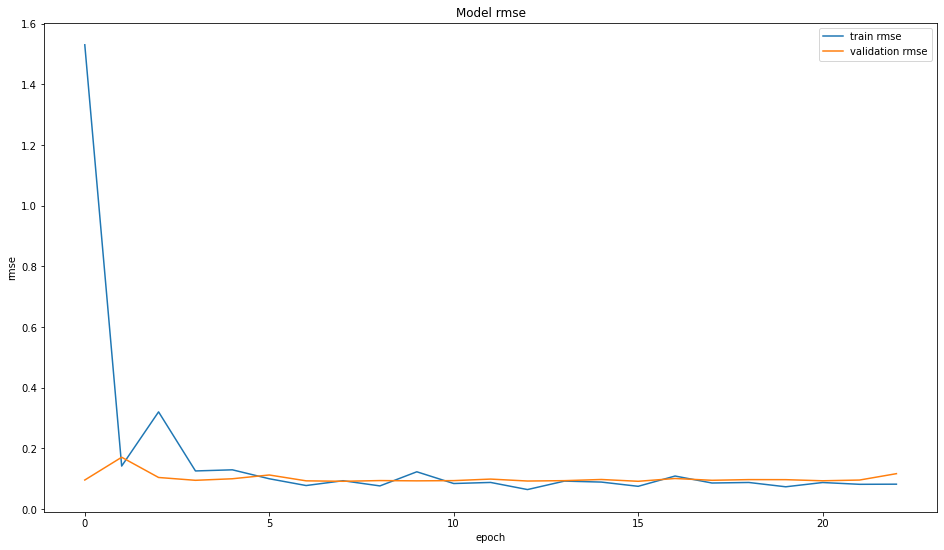

In [141]:
plt.figure(figsize=(16,9))
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train rmse', 'validation rmse'])
plt.show()

In [154]:
pred = lstm_model.predict(x_test)
pred_Inverse = Y_scaler.inverse_transform(pred)
print(pred_Inverse.shape)

(18720, 1)


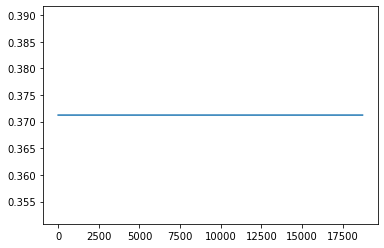

In [155]:
plt.plot(pred_Inverse)

In [144]:
temp = pd.concat([df[test_idx:].reset_index()[['시간']], pd.DataFrame(pred_Inverse)],axis=1)
temp['일자'] = temp['시간'].apply(lambda x: str(x)[:10])

temp['yy'] = temp['일자'].apply(lambda x : x.split('-')[0])
temp['mm'] = temp['일자'].apply(lambda x : x.split('-')[1])
temp['dd'] = temp['일자'].apply(lambda x : x.split('-')[2])

temp.groupby(['yy','mm','dd'])[0].sum().reset_index().rename(columns={0:'heat_supply_day'})
# np.round(temp.groupby(['yy','mm','dd'])[0].sum(),1).reset_index().rename(columns={0:'heat_supply_day'}).to_csv('../result_lstm.csv',index=False)

,yy,mm,dd,heat_supply_day
0,2022,03,04,164.457596
1,2022,03,05,164.470459
2,2022,03,06,164.477280
3,2022,03,07,164.459152
4,2022,03,08,164.460236
5,2022,03,09,164.461105
6,2022,03,10,164.459854
7,2022,03,11,164.458313
8,2022,03,12,164.463013
9,2022,03,13,164.467545


-----------

In [168]:
new_model = tf.keras.models.load_model('LSTM_Multivariate_real.h5')
pred = new_model.predict(x_test)

In [170]:
# pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse = np.expm1(pred)
pred_Inverse

array([[0.3030883],
       [0.3030883],
       [0.3030883],
       ...,
       [0.3030883],
       [0.3030883],
       [0.3030883]], dtype=float32)

In [145]:
temp = pd.concat([df[test_idx:].reset_index()[['시간']], pd.DataFrame(pred_Inverse)],axis=1)
temp['일자'] = temp['시간'].apply(lambda x: x[:10])

temp['yy'] = temp['일자'].apply(lambda x : x.split('-')[0])
temp['mm'] = temp['일자'].apply(lambda x : x.split('-')[1])
temp['dd'] = temp['일자'].apply(lambda x : x.split('-')[2])
temp.groupby(['yy','mm','dd'])[0].sum().reset_index().rename(columns={0:'heat_supply_day'})

,yy,mm,dd,heat_supply_day
0,2022,03,04,432.831635
1,2022,03,05,432.831635
2,2022,03,06,432.831635
3,2022,03,07,432.831635
4,2022,03,08,432.831635
5,2022,03,09,432.831635
6,2022,03,10,432.831635
7,2022,03,11,432.831635
8,2022,03,12,432.831635
9,2022,03,13,432.831635


In [171]:
import matplotlib.pyplot as plt

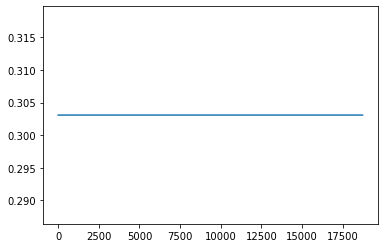

In [172]:
plt.plot(pred_Inverse)